## Manifold testing for continuous case ambiguity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir('..')
os.getcwd()

'd:\\FAU_Courses\\FAU Summer 2024\\Seminar\\Codes'

In [2]:
def generate_two_dimensional_data(num_samples_per_class):
    """Generate two dimentional data set for multiple classes"""
    np.random.seed(0)  

    # Class 0
    mean_0 = [0, 0]
    cov_0 = [[1, 0.5], [0.5, 1]] 
    class_0_data = np.random.multivariate_normal(mean_0, cov_0, num_samples_per_class)
    label_0 = np.zeros(num_samples_per_class)

    # Class 1
    mean_1 = [-2.5, 2.5]
    cov_1 = [[1, -0.5], [-0.5, 1]] 
    class_1_data = np.random.multivariate_normal(mean_1, cov_1, num_samples_per_class)
    label_1 = np.ones(num_samples_per_class)

    # Concatenate data and labels
    data = np.vstack((class_0_data, class_1_data))
    labels = np.concatenate((label_0, label_1))

    # Create DataFrame
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    df['class'] = labels

    return df

In [3]:
def plot_hypercube_and_samples(df, feature_x, feature_y, class_column):
    classes = df[class_column].unique()
    plt.figure(figsize=(10, 8))
    
    for cls in classes:
        subset = df[df[class_column] == cls]
        min_x, max_x = subset[feature_x].min(), subset[feature_x].max()
        min_y, max_y = subset[feature_y].min(), subset[feature_y].max()
        
        # Plotting samples
        plt.scatter(subset[feature_x], subset[feature_y], label=f'Class {cls}')
        
        # Plotting hypercube boundaries
        plt.plot([min_x, max_x], [min_y, min_y], 'k--')
        plt.plot([min_x, max_x], [max_y, max_y], 'k--')
        plt.plot([min_x, min_x], [min_y, max_y], 'k--')
        plt.plot([max_x, max_x], [min_y, max_y], 'k--')
    
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title('Hypercubes and Samples Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

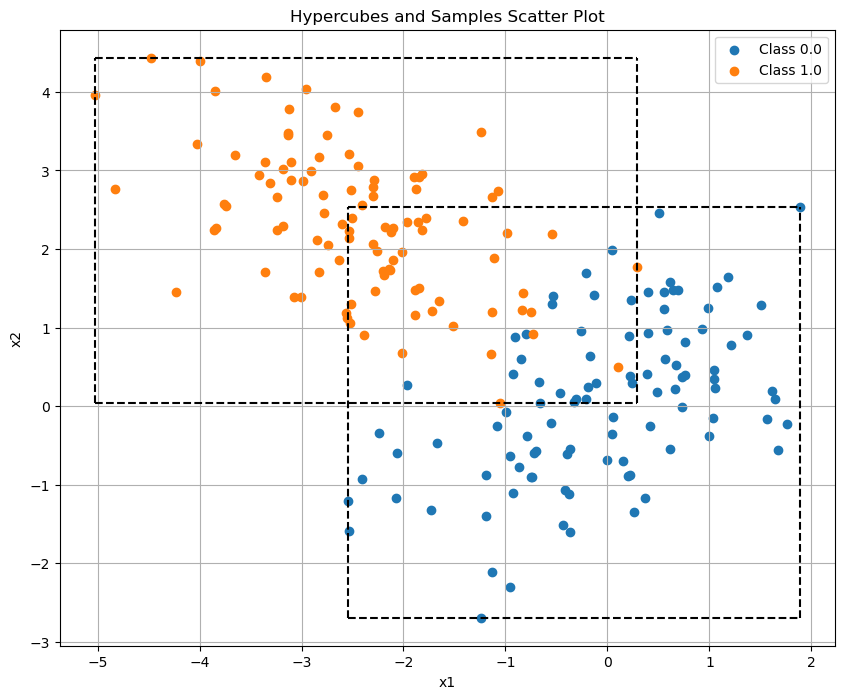

In [4]:
df = generate_two_dimensional_data(100)
plot_hypercube_and_samples(df, 'x1', 'x2', 'class')

In [5]:
# Caculate continuous case ambiguity using recatngular bounding box methods
from src.continuous import calculate_continuous_ambiguity
ambiguity, overlap_regions, samples_in_overlap = calculate_continuous_ambiguity(df, 'class')
ambiguity, overlap_regions, samples_in_overlap

(0.32999999999999996,
 [((0.0, 1.0),
   array([-2.54168126,  0.03537066]),
   array([0.29087077, 2.53776333]))],
 {'0.0-1.0': {0.0: 24, 1.0: 42}})

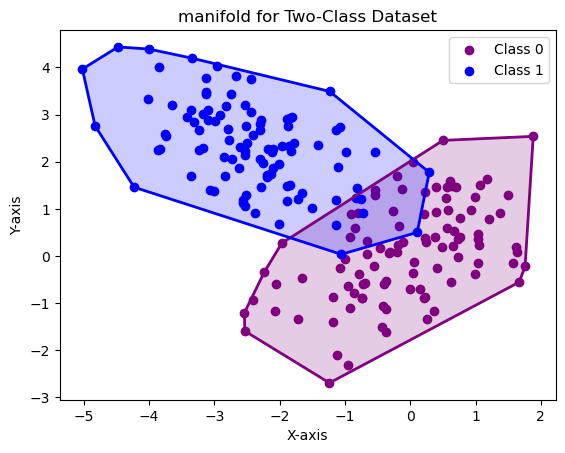

In [6]:
# Testing tighter bounding surf
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

np.random.seed(0)
class_0 = df[df['class']==0][['x1', 'x2']].values
class_1 = df[df['class']==1][['x1', 'x2']].values

def plot_convex_hull(points, ax, color):
    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], color=color, linewidth=2)
        ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], color=color, alpha=0.2)

fig, ax = plt.subplots()

ax.scatter(class_0[:, 0], class_0[:, 1], color='purple', label='Class 0')
plot_convex_hull(class_0, ax, color='purple')

ax.scatter(class_1[:, 0], class_1[:, 1], color='blue', label='Class 1')
plot_convex_hull(class_1, ax, color='blue')

# Add legend and show plot
ax.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('manifold for Two-Class Dataset')
plt.show()

In [7]:
def calculate_ambiguity(df):
    class_0 = df[df['class']==0][['x1', 'x2']].values
    class_1 = df[df['class']==1][['x1', 'x2']].values 

    hull_0 = ConvexHull(class_0)
    hull_1 = ConvexHull(class_1)

    def points_in_hull(points, hull):
        coef = hull.equations[:, :-1]  # Convexhull.equations returns all the facets eqautions 
        const = hull.equations[:, -1]
        return np.all((np.dot(points, coef.T)+const) <=0, axis =1)
    
    class_0_overlap = class_0[points_in_hull(class_0, hull_1)]
    class_1_overlap = class_1[points_in_hull(class_1, hull_0)]

    class_0_counts = len(class_0_overlap)
    class_1_counts = len(class_1_overlap)

    ambiguity = .5*(class_0_counts/len(class_0) + class_1_counts/len(class_1))

    return ambiguity


In [8]:
calculate_ambiguity(df)

0.095

In [9]:
## generalized ambiguity calculation functions
def calc_ambiguity(df, class_column):
    classes = df[class_column].unique()
    features = df.columns[df.columns != class_column]
    K = len(classes)   # total number of classes
    class_hulls = {}

    for cls in classes:
        class_points = df[df[class_column] == cls][features].values
        if len(class_points) < len(features):
            raise ValueError(f"class {cls} has insufficient points for convex hull")
        class_hulls[cls] = ConvexHull(class_points)

    def points_in_hull(points, hull):
        coef = hull.equations[:, :-1]
        const = hull.equations[:, -1]
        return np.all(np.dot(points, coef.T) + const <= 0, axis=1)
    
    total_ambiguity = 0
    for cls_j in classes:
        class_j_points = df[df[class_column] == cls_j][features].values
        total_points_j = len(class_j_points)
        overlap_count_j = 0
        for cls_k in classes:
            if cls_k != cls_j:
                overlap_points = class_j_points[points_in_hull(class_j_points, class_hulls[cls_k])]
                overlap_count_j += len(overlap_points)

        if total_points_j > 0:
            total_ambiguity += overlap_count_j / total_points_j
    ambiguity = total_ambiguity / K
    return ambiguity


In [10]:
ambiguity = calc_ambiguity(df, 'class')
ambiguity

0.095

In [11]:
1 - ambiguity

0.905

In [ ]:
from src.model import Model

model = Model('rf')
model.data_split(df)
# model.train(df)
# result = model.evaluate()
cross_val = model.cross_validate_with_metrics(cv=5)


cross_val

AttributeError: 'Model' object has no attribute 'cross_validate'

In [13]:
from src.model import Model

model = Model('lr')
model.train(df)
result = model.evaluate()
cross_val = model.cross_validate(cv=8)


result, cross_val

(0.975,
 {'fit_time': array([0.00310302, 0.00404   , 0.00405574, 0.00399256, 0.00400114,
         0.00401688, 0.00408459, 0.00480509]),
  'score_time': array([0.00401616, 0.        , 0.        , 0.        , 0.00321746,
         0.        , 0.        , 0.        ]),
  'test_score': array([0.96, 0.96, 0.96, 0.96, 0.96, 0.92, 0.96, 0.92]),
  'train_score': array([0.96571429, 0.96      , 0.96      , 0.96571429, 0.96      ,
         0.96571429, 0.96      , 0.96571429])})

In [16]:
1-cross_val[1]

array([0.  , 0.05, 0.05, 0.  , 0.  , 0.  , 0.05, 0.1 ])